In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **Data Loading**

In [2]:
# import fnmatch
# import os
# import random
# from PIL import Image
# from shutil import copyfile


# import os
# from os.path import join
# from shutil import copy2
# from PIL import Image

# def copy_valid_images(folder, target_dir, min_width=512, min_height=512, min_size_kb=100):
#     """
#     Copy images satisfying both size and dimension criteria to the target directory.
#     """
#     train_dir = join(target_dir, 'train')
#     dev_dir = join(target_dir, 'dev')
#     test_dir = join(target_dir, 'test')
    
#     # Create target directory and subfolders if they don't exist
#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(dev_dir, exist_ok=True)
#     os.makedirs(test_dir, exist_ok=True)
    
#     for root, _, files in os.walk(folder):
#         for file_name in files:
#             file_path = os.path.join(root, file_name)
#             if file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
#                 try:
#                     with Image.open(file_path) as img:
#                         width, height = img.size
#                         if width >= min_width and height >= min_height and os.path.getsize(file_path) >= min_size_kb * 1024:
#                             if len(os.listdir(train_dir)) < 10816:
#                                 copy2(file_path, join(train_dir, file_name))
#                             elif len(os.listdir(dev_dir)) < 2000:
#                                 copy2(file_path, join(dev_dir, file_name))
#                             elif len(os.listdir(test_dir)) < 1000:
#                                 copy2(file_path, join(test_dir, file_name))
#                             else:
#                                 break  # Stop copying once the limits are reached
#                 except Exception as e:
#                     print(f"Error processing image: {file_path}, {e}")

In [3]:
# copy_valid_images('/kaggle/input/tagged-anime-illustrations/danbooru-images/danbooru-images', '/kaggle/working/data')

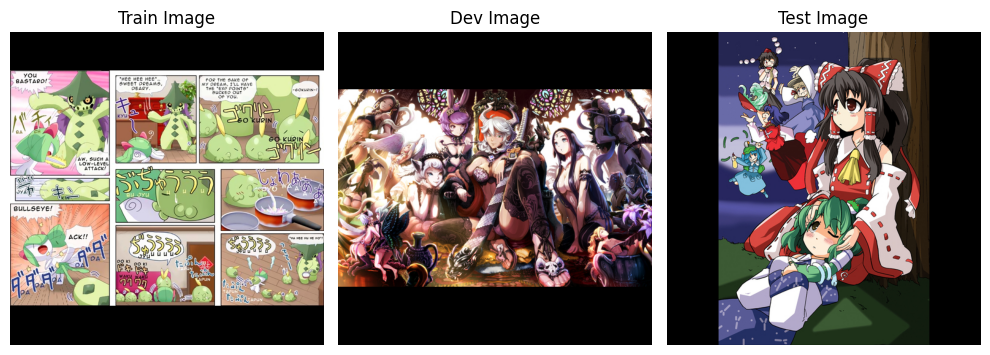

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the paths to the train, test, and dev directories
train_dir = '/kaggle/input/anime-sr-selected-dataset/train'
dev_dir = '/kaggle/input/anime-sr-selected-dataset/dev'
test_dir = '/kaggle/input/anime-sr-selected-dataset/test'

# Get the paths to one image from each directory
train_image_path = os.path.join(train_dir, os.listdir(train_dir)[0])
dev_image_path = os.path.join(dev_dir, os.listdir(dev_dir)[0])
test_image_path = os.path.join(test_dir, os.listdir(test_dir)[0])

# Open and load the images
train_image = Image.open(train_image_path)
dev_image = Image.open(dev_image_path)
test_image = Image.open(test_image_path)

# Plot the images
plt.figure(figsize=(10, 5))

# Plot the train image
plt.subplot(1, 3, 1)
plt.imshow(train_image)
plt.title('Train Image')
plt.axis('off')

# Plot the dev image
plt.subplot(1, 3, 2)
plt.imshow(dev_image)
plt.title('Dev Image')
plt.axis('off')

# Plot the test image
plt.subplot(1, 3, 3)
plt.imshow(test_image)
plt.title('Test Image')
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


## **Model Building**

In [5]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return x + self.net(x)
        
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor, kernel_size=3, padding=1):
        super(UpsampleBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * (scale_factor ** 2), kernel_size=kernel_size, padding=padding),
            nn.PixelShuffle(scale_factor),
            nn.PReLU()
        )
    
    def forward(self, x):
        return self.net(x)
        
class Generator(nn.Module):
    def __init__(self, n_residual=8):
        super(Generator, self).__init__()
        self.n_residual = n_residual
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        
        for i in range(n_residual):
            self.add_module('residual' + str(i+1), ResidualBlock(64, 64))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.PReLU()
        )
        
        self.upsample = nn.Sequential(
            UpsampleBlock(64, 2),
            UpsampleBlock(64, 2),
            nn.Conv2d(64, 3, kernel_size=9, padding=4)
        )

    def forward(self, x):
        y = self.conv1(x)
        cache = y.clone()
        
        for i in range(self.n_residual):
            y = getattr(self, 'residual' + str(i+1))(y)
            
        y = self.conv2(y)
        y = self.upsample(y + cache)
        return (torch.tanh(y) + 1.0) / 2.0
    
class Discriminator(nn.Module):
    def __init__(self, leaky_slope=0.2):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(leaky_slope),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x): 
        y = self.net(x)
        return torch.sigmoid(y).view(y.size()[0])
        
class Discriminator_WGAN(nn.Module):
    def __init__(self, leaky_slope=0.2):
        super(Discriminator_WGAN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x): 
        y = self.net(x)
        return y.view(y.size()[0])

def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.randn(real_samples.size(0), 1, 1, 1)
    if torch.cuda.is_available():
        alpha = alpha.cuda()
        
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size())
    if torch.cuda.is_available():
        fake = fake.cuda()
        
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## **Utils**

In [6]:
import numpy as np
import torch
import os
from os import listdir
from os.path import join
from PIL import Image
import torch.utils.data
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.utils as utils
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize, Normalize

# Function to check if a file is an image file
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

# Calculate the valid crop size for given parameters
def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

# Transformation to convert tensor to image
def to_image():
    return Compose([
        ToPILImage(),
        ToTensor()
    ])

from PIL import ImageOps

class TrainDataset(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDataset, self).__init__()
        # Get list of image file names
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        # Calculate valid crop size
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        # Define preprocessing steps for high-resolution and low-resolution images
        self.hr_preprocess = Compose([CenterCrop(384), RandomCrop(crop_size), ToTensor()])
        self.lr_preprocess = Compose([ToPILImage(), Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC), ToTensor()])

    def __getitem__(self, index):
        # Load high-resolution image
        hr_image = Image.open(self.image_filenames[index])
        # Check if the image is grayscale and convert it to RGB if necessary
        if hr_image.mode != 'RGB':
            hr_image = hr_image.convert('RGB')
        # Preprocess low-resolution image
        hr_image = self.hr_preprocess(hr_image)
        lr_image = self.lr_preprocess(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)
            
# Dataset class for development data
class DevDataset(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(DevDataset, self).__init__()
        self.upscale_factor = upscale_factor
        # Get list of image file names
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]

    def __getitem__(self, index):
        # Load high-resolution image
        hr_image = Image.open(self.image_filenames[index])
        if hr_image.mode != 'RGB':
            hr_image = hr_image.convert('RGB')
        # Calculate valid crop size
        crop_size = calculate_valid_crop_size(128, self.upscale_factor)
        # Resize images for LR and HR restoration
        lr_scale = Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
        hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
        hr_image = CenterCrop(crop_size)(hr_image)
        lr_image = lr_scale(hr_image)
        hr_restore_img = hr_scale(lr_image)
        norm = ToTensor()
        return norm(lr_image), norm(hr_restore_img), norm(hr_image)

    def __len__(self):
        return len(self.image_filenames)

# Function to print the first parameter of a network
def print_first_parameter(net):    
    for name, param in net.named_parameters():
        if param.requires_grad:
            print(str(name) + ':' + str(param.data[0]))
            return

# Function to check gradients of a model
def check_grads(model, model_name):
    grads = []
    for p in model.parameters():
        if not p.grad is None:
            grads.append(float(p.grad.mean()))

    grads = np.array(grads)
    if grads.any() and grads.mean() > 100:
        print('WARNING!' + model_name + ' gradients mean is over 100.')
        return False
    if grads.any() and grads.max() > 100:
        print('WARNING!' + model_name + ' gradients max is over 100.')
        return False
        
    return True

# Function to get gradients for discriminator network
def get_grads_D(net):
    top = 0
    bottom = 0
    for name, param in net.named_parameters():
        if param.requires_grad:
            # Hardcoded param name, subject to change of the network
            if name == 'net.0.weight':
                top = param.grad.abs().mean()
            # Hardcoded param name, subject to change of the network
            if name == 'net.26.weight':
                bottom = param.grad.abs().mean()
    return top, bottom

# Function to get gradients for discriminator WGAN network
def get_grads_D_WAN(net):
    top = 0
    bottom = 0
    for name, param in net.named_parameters():
        if param.requires_grad:
            # Hardcoded param name, subject to change of the network
            if name == 'net.0.weight':
                top = param.grad.abs().mean()
            # Hardcoded param name, subject to change of the network
            if name == 'net.19.weight':
                bottom = param.grad.abs().mean()
    return top, bottom

# Function to get gradients for generator network
def get_grads_G(net):
    top = 0
    bottom = 0
    for name, param in net.named_parameters():
        if param.requires_grad:
            # Hardcoded param name, subject to change of the network
            if name == 'conv1.0.weight':
                top = param.grad.abs().mean()
            # Hardcoded param name, subject to change of the network
            if name == 'upsample.2.weight':
                bottom = param.grad.abs().mean()
    return top, bottom

## **Evaluation**

In [7]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    """
    Generate a 1D Gaussian kernel.

    Args:
        window_size (int): Size of the kernel.
        sigma (float): Standard deviation of the Gaussian distribution.

    Returns:
        torch.Tensor: 1D Gaussian kernel.
    """
    gauss = torch.Tensor([exp(-(x - window_size//2)**2 / float(2*sigma**2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    """
    Create a 2D Gaussian window for SSIM calculation.

    Args:
        window_size (int): Size of the window.
        channel (int): Number of image channels.

    Returns:
        torch.Tensor: 2D Gaussian window.
    """
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    """
    Compute the SSIM between two images.

    Args:
        img1 (torch.Tensor): First input image.
        img2 (torch.Tensor): Second input image.
        window (torch.Tensor): 2D Gaussian window.
        window_size (int): Size of the window.
        channel (int): Number of image channels.
        size_average (bool): Whether to compute the mean SSIM.

    Returns:
        torch.Tensor: SSIM value.
    """
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1) * (2*sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    """
    SSIM module to compute the Structural Similarity Index.
    """
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        """
        Compute the SSIM between two images.

        Args:
            img1 (torch.Tensor): First input image.
            img2 (torch.Tensor): Second input image.

        Returns:
            torch.Tensor: SSIM value.
        """
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size=11, size_average=True):
    """
    Compute the SSIM between two images.

    Args:
        img1 (torch.Tensor): First input image.
        img2 (torch.Tensor): Second input image.
        window_size (int): Size of the Gaussian window.
        size_average (bool): Whether to compute the mean SSIM.

    Returns:
        torch.Tensor: SSIM value.
    """
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

## **Training**

In [8]:
!pip install tensorboard_logger -q

In [9]:
# Check if the directory exists
if not os.path.exists('/kaggle/working/cp'):
    # Create the directory if it doesn't exist
    os.mkdir('/kaggle/working/cp')

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as utils
from tensorboard_logger import configure, log_value
from tqdm import tqdm
from math import log10
import numpy as np
# import pytorch_ssim


def train_collate_fn(batch):
    # Unzip the batch into LR and HR images
    lr_images, hr_images = zip(*batch)
    # Stack LR and HR images along the batch dimension
#     print([img.shape for img in lr_images])
    lr_images = torch.stack(lr_images, dim=0)
    hr_images = torch.stack(hr_images, dim=0)
    return lr_images, hr_images

def dev_collate_fn(batch):
    # Unzip the batch into LR, HR_restore, and HR images
#     print([img.shape for img in lr_images])
    lr_images, hr_restore_images, hr_images = zip(*batch)
    # Stack LR, HR_restore, and HR images along the batch dimension
    lr_images = torch.stack(lr_images, dim=0)
    hr_restore_images = torch.stack(hr_restore_images, dim=0)
    hr_images = torch.stack(hr_images, dim=0)
    return lr_images, hr_restore_images, hr_images



def main():
    # Configuration
    n_epoch_pretrain = 1
    use_tensorboard = True
    crop_size = 96
    num_epochs = 100
    batch_size = 2
    train_set = "/kaggle/input/anime-sr-selected-dataset/train"
    check_point = -1

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data Loading
    train_set = TrainDataset(train_set, crop_size=crop_size, upscale_factor=4)
    train_loader = DataLoader(dataset=train_set, num_workers=2, batch_size=batch_size, shuffle=True, collate_fn = train_collate_fn)
    dev_set = DevDataset('/kaggle/input/anime-sr-selected-dataset/dev', upscale_factor=4)
    dev_loader = DataLoader(dataset=dev_set, num_workers=1, batch_size=1, shuffle=False, collate_fn = dev_collate_fn)

    # Model Initialization
    netG = Generator().to(device)
    netD = Discriminator_WGAN().to(device)
    mse = nn.MSELoss()

    # Optimizers
    optimizerG = optim.Adam(netG.parameters(), lr=1e-4)
    optimizerD = optim.Adam(netD.parameters(), lr=1e-4)

#     Tensorboard Logging
    if use_tensorboard:
        configure('/kaggle/working/log', flush_secs=5)

    # Pre-train generator using only MSE loss
    if check_point == -1:
        for epoch in range(1, n_epoch_pretrain + 1):
            netG.train()
            cache = {'g_loss': 0}
            for lowres, real_img_hr in train_loader:
                lowres, real_img_hr = lowres.to(device), real_img_hr.to(device)
                fake_img_hr = netG(lowres)
                # Train G
                netG.zero_grad()
                image_loss = mse(fake_img_hr, real_img_hr)
                cache['g_loss'] += image_loss.item()
                image_loss.backward()
                optimizerG.step()
                # Print information by tqdm
            print(f"Pre-training Epoch [{epoch}/{n_epoch_pretrain}] Loss_G: {cache['g_loss']}")

    # Training loop
    for epoch in range(1 + max(check_point, 0), num_epochs + 1 + max(check_point, 0)):
        netG.train()
        netD.train()
        cache = {'mse_loss': 0, 'adv_loss': 0, 'g_loss': 0, 'd_loss': 0}
        g_loss_epoch = []
        d_loss_epoch = []
        image_loss_epoch = []
        adv_loss_epoch= []
        for lowres, real_img_hr in train_loader:
            lowres, real_img_hr = lowres.to(device), real_img_hr.to(device)
            fake_img_hr = netG(lowres)
            # Train D
            netD.zero_grad()
            logits_real = netD(real_img_hr).mean()
            logits_fake = netD(fake_img_hr).mean()
            gradient_penalty = compute_gradient_penalty(netD, real_img_hr, fake_img_hr)
            d_loss = logits_fake - logits_real + 10 * gradient_penalty
            cache['d_loss'] += d_loss.item()
            d_loss.backward(retain_graph=True)
            optimizerD.step()
            # Train G
            netG.zero_grad()
            image_loss = mse(fake_img_hr, real_img_hr)
            adversarial_loss = -1 * netD(fake_img_hr).mean()
            g_loss = image_loss + 1e-3 * adversarial_loss
            cache['mse_loss'] += image_loss.item()
            cache['adv_loss'] += adversarial_loss.item()
            cache['g_loss'] += g_loss.item()
            g_loss.backward()
            optimizerG.step()
            g_loss_epoch.append(g_loss.item())
            d_loss_epoch.append(d_loss.item())
            image_loss_epoch.append(image_loss.item())
            adv_loss_epoch.append(adversarial_loss.item())
            # Print information by tqdm
        print(f'Training Epoch [{epoch}/{num_epochs}] Loss_D: {np.average(d_loss_epoch)} Loss_G: {np.average(g_loss_epoch)} = {np.average(image_loss_epoch)} + {np.average(adv_loss_epoch)}')

        # Logging
        if use_tensorboard:
            log_value('d_loss', cache['d_loss'] / len(train_loader), epoch)
            log_value('mse_loss', cache['mse_loss'] / len(train_loader), epoch)
            log_value('adv_loss', cache['adv_loss'] / len(train_loader), epoch)
            log_value('g_loss', cache['g_loss'] / len(train_loader), epoch)

        # Saving model parameters
        if torch.cuda.is_available():
            torch.save(netG.state_dict(), f'/kaggle/working/cp/netG_epoch_{epoch}_gpu.pth')
            if epoch % 5 == 0:
                torch.save(netD.state_dict(), f'/kaggle/working/cp/netD_epoch_{epoch}_gpu.pth')
                torch.save(optimizerG.state_dict(), f'/kaggle/working/cp/optimizerG_epoch_{epoch}_gpu.pth')
                torch.save(optimizerD.state_dict(), f'/kaggle/working/cp/optimizerD_epoch_{epoch}_gpu.pth')
        else:
            torch.save(netG.state_dict(), f'/kaggle/working/cp/netG_epoch_{epoch}_cpu.pth')
            if epoch % 5 == 0:
                torch.save(netD.state_dict(), f'/kaggle/working/cp/netD_epoch_{epoch}_cpu.pth')
                torch.save(optimizerG.state_dict(), f'/kaggle/working/cp/optimizerG_epoch_{epoch}_cpu.pth')
                torch.save(optimizerD.state_dict(), f'/kaggle/working/cp/optimizerD_epoch_{epoch}_cpu.pth')

        # Visualize results
        with torch.no_grad():
            netG.eval()
            out_path = '/kaggle/working/vis/'
            if not os.path.exists(out_path):
                os.makedirs(out_path)
            dev_bar = tqdm(dev_loader)
            valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
            dev_images = []
            for val_lr, val_hr_restore, val_hr in dev_bar:
                lr, hr = val_lr.to(device), val_hr.to(device)
                sr = netG(lr)
                psnr = 10 * log10(1 / ((sr - hr) ** 2).mean().item())
                ssim_value = ssim(sr, hr).item()
                dev_bar.set_description(desc=f'[converting LR images to SR images] PSNR: {psnr} dB SSIM: {ssim_value}')
                valing_results['ssim'] += ssim_value
                valing_results['psnr'] += psnr
                if len(dev_images) < 60:
                    dev_images.extend([to_image()(val_hr_restore.squeeze(0)), to_image()(hr.data.cpu().squeeze(0)), to_image()(sr.data.cpu().squeeze(0))])
            dev_images = torch.stack(dev_images)
            dev_images = torch.chunk(dev_images, dev_images.size(0) // 3)
            dev_save_bar = tqdm(dev_images, desc='[saving training results]')
            index = 1
            for image in dev_save_bar:
                image = utils.make_grid(image, nrow=3, padding=5)
                utils.save_image(image, f'{out_path}epoch_{epoch}_index_{index}.png', padding=5)
                index += 1
            if use_tensorboard:
                log_value('ssim', valing_results['ssim'] / len(dev_loader), epoch)
                log_value('psnr', valing_results['psnr'] / len(dev_loader), epoch)

2024-05-01 19:35:04.603202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:35:04.603298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:35:04.792200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
main()

Pre-training Epoch [1/1] Loss_G: 65.00716409430606
Training Epoch [1/100] Loss_D: 0.6799376782056732 Loss_G: -0.0011307930568396388 = 0.009759779422543384 + -10.89057194822731


[converting LR images to SR images] PSNR: 22.95001139118206 dB SSIM: 0.7064616680145264: 100%|██████████| 2000/2000 [00:26<00:00, 74.26it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 51.68it/s]


Training Epoch [2/100] Loss_D: -1.9962106532279125 Loss_G: 0.01130782352699428 = 0.009029868851401519 + 2.2779545615290804


[converting LR images to SR images] PSNR: 24.99682119012343 dB SSIM: 0.7758302688598633: 100%|██████████| 2000/2000 [00:21<00:00, 92.06it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.40it/s]


Training Epoch [3/100] Loss_D: -1.9472713096717582 Loss_G: 0.009801027180923452 = 0.008510960305231503 + 1.290066816042227


[converting LR images to SR images] PSNR: 25.112874039693452 dB SSIM: 0.7959005236625671: 100%|██████████| 2000/2000 [00:21<00:00, 93.23it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.37it/s]


Training Epoch [4/100] Loss_D: -1.863421428476091 Loss_G: 0.010190442598830153 = 0.008201515098017706 + 1.9889274053509793


[converting LR images to SR images] PSNR: 25.144104067482118 dB SSIM: 0.7842553853988647: 100%|██████████| 2000/2000 [00:21<00:00, 92.78it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.27it/s]


Training Epoch [5/100] Loss_D: -1.7434969104245408 Loss_G: 0.009994475564678917 = 0.007953799342433702 + 2.040676131153606


[converting LR images to SR images] PSNR: 25.210085692277865 dB SSIM: 0.7928337454795837: 100%|██████████| 2000/2000 [00:21<00:00, 93.27it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.64it/s]


Training Epoch [6/100] Loss_D: -1.6613851110149553 Loss_G: 0.008079983389738516 = 0.00785445942174246 + 0.2255239618291869


[converting LR images to SR images] PSNR: 25.686693323125787 dB SSIM: 0.813264787197113: 100%|██████████| 2000/2000 [00:21<00:00, 92.71it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.88it/s]


Training Epoch [7/100] Loss_D: -1.612731290649364 Loss_G: 0.007291206693889493 = 0.007717147798294831 + -0.42594108101911843


[converting LR images to SR images] PSNR: 25.226631460384215 dB SSIM: 0.8012349009513855: 100%|██████████| 2000/2000 [00:21<00:00, 91.85it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.31it/s]


Training Epoch [8/100] Loss_D: -1.5426396822808541 Loss_G: 0.006437352421172907 = 0.007662482071879645 + -1.2251295930039159


[converting LR images to SR images] PSNR: 26.0381858498633 dB SSIM: 0.8189133405685425: 100%|██████████| 2000/2000 [00:22<00:00, 90.41it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.10it/s]


Training Epoch [9/100] Loss_D: -1.4751396116415885 Loss_G: 0.005477164480073807 = 0.007534620000507814 + -2.0574554262466496


[converting LR images to SR images] PSNR: 25.556215035301882 dB SSIM: 0.8113333582878113: 100%|██████████| 2000/2000 [00:21<00:00, 93.05it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.26it/s]


Training Epoch [10/100] Loss_D: -1.455407276614855 Loss_G: 0.004823922468890945 = 0.007506867794226304 + -2.682945198747302


[converting LR images to SR images] PSNR: 26.014616790035966 dB SSIM: 0.8171463012695312: 100%|██████████| 2000/2000 [00:21<00:00, 92.13it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.26it/s]


Training Epoch [11/100] Loss_D: -1.450202006324864 Loss_G: 0.004134971132819605 = 0.007349069718275024 + -3.214098431816815


[converting LR images to SR images] PSNR: 25.619559422791212 dB SSIM: 0.8171035647392273: 100%|██████████| 2000/2000 [00:21<00:00, 91.07it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.28it/s]


Training Epoch [12/100] Loss_D: -1.4319251080457955 Loss_G: 0.003839956152552674 = 0.007345610359270884 + -3.505654042001852


[converting LR images to SR images] PSNR: 26.44850681030185 dB SSIM: 0.8285104036331177: 100%|██████████| 2000/2000 [00:21<00:00, 91.16it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.80it/s]


Training Epoch [13/100] Loss_D: -1.4242353312222227 Loss_G: 0.0032610841667008454 = 0.0072321510681181735 + -3.971066709492802


[converting LR images to SR images] PSNR: 25.623321983486413 dB SSIM: 0.8046221733093262: 100%|██████████| 2000/2000 [00:21<00:00, 92.66it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 50.76it/s]


Training Epoch [14/100] Loss_D: -1.4031172360900357 Loss_G: 0.0030312656550858905 = 0.007220008264184314 + -4.1887424136167555


[converting LR images to SR images] PSNR: 25.88163441253989 dB SSIM: 0.8082372546195984: 100%|██████████| 2000/2000 [00:21<00:00, 93.04it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.09it/s]


Training Epoch [15/100] Loss_D: -1.4325409107188007 Loss_G: 0.0027224746120914703 = 0.007212110294358085 + -4.489635466484314


[converting LR images to SR images] PSNR: 26.240831064442563 dB SSIM: 0.8308762907981873: 100%|██████████| 2000/2000 [00:21<00:00, 92.87it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.11it/s]


Training Epoch [16/100] Loss_D: -1.4179617454464972 Loss_G: 0.0029061433400751862 = 0.007184582679653469 + -4.278439136484456


[converting LR images to SR images] PSNR: 26.480746387501377 dB SSIM: 0.8287862539291382: 100%|██████████| 2000/2000 [00:21<00:00, 91.87it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.81it/s]


Training Epoch [17/100] Loss_D: -1.4138327914795745 Loss_G: 0.0023697105588374374 = 0.007090717413809577 + -4.721006633976293


[converting LR images to SR images] PSNR: 26.244147887707328 dB SSIM: 0.818720817565918: 100%|██████████| 2000/2000 [00:22<00:00, 90.89it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.34it/s]


Training Epoch [18/100] Loss_D: -1.3884582816142765 Loss_G: 0.002120101602685222 = 0.007035321257927325 + -4.915219421160942


[converting LR images to SR images] PSNR: 26.46594673570227 dB SSIM: 0.826988697052002: 100%|██████████| 2000/2000 [00:21<00:00, 91.09it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.17it/s]


Training Epoch [19/100] Loss_D: -1.3946572659718364 Loss_G: 0.001989978835932647 = 0.0069725449582340214 + -4.98256588402995


[converting LR images to SR images] PSNR: 25.67165778203018 dB SSIM: 0.8200706243515015: 100%|██████████| 2000/2000 [00:22<00:00, 89.82it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.27it/s]


Training Epoch [20/100] Loss_D: -1.3882375190439917 Loss_G: 0.0019503669225946262 = 0.0070004383078896846 + -5.050071137964164


[converting LR images to SR images] PSNR: 26.58053292084044 dB SSIM: 0.834594190120697: 100%|██████████| 2000/2000 [00:21<00:00, 91.55it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.23it/s]


Training Epoch [21/100] Loss_D: -1.3824300426774228 Loss_G: 0.0019248999161773207 = 0.006960150005925135 + -5.0352498481515795


[converting LR images to SR images] PSNR: 25.828337946690908 dB SSIM: 0.8031851649284363: 100%|██████████| 2000/2000 [00:22<00:00, 90.89it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.61it/s]


Training Epoch [22/100] Loss_D: -1.3723605526659428 Loss_G: 0.0020262766776698747 = 0.006889611528396345 + -4.863334617471411


[converting LR images to SR images] PSNR: 26.799552128641263 dB SSIM: 0.8358783721923828: 100%|██████████| 2000/2000 [00:22<00:00, 90.05it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.38it/s]


Training Epoch [23/100] Loss_D: -1.38247484485543 Loss_G: 0.0019887054799008013 = 0.0068515052157501555 + -4.862799503474039


[converting LR images to SR images] PSNR: 26.780530517844007 dB SSIM: 0.8352414965629578: 100%|██████████| 2000/2000 [00:22<00:00, 87.97it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.17it/s]


Training Epoch [24/100] Loss_D: -1.3725347985119487 Loss_G: 0.0016290745805117534 = 0.0068679040054680975 + -5.2388291749249065


[converting LR images to SR images] PSNR: 26.484195417662075 dB SSIM: 0.8207146525382996: 100%|██████████| 2000/2000 [00:22<00:00, 88.57it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.22it/s]


Training Epoch [25/100] Loss_D: -1.3650127907743883 Loss_G: 0.0015277893189758443 = 0.006856914089229786 + -5.3291245169631765


[converting LR images to SR images] PSNR: 26.160685678231495 dB SSIM: 0.8115142583847046: 100%|██████████| 2000/2000 [00:22<00:00, 88.81it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.88it/s]


Training Epoch [26/100] Loss_D: -1.3476893835067825 Loss_G: 0.0017004626496110666 = 0.00679462709385701 + -5.094164197314559


[converting LR images to SR images] PSNR: 26.561986208434732 dB SSIM: 0.824520468711853: 100%|██████████| 2000/2000 [00:22<00:00, 89.46it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.15it/s]


Training Epoch [27/100] Loss_D: -1.3188448164578646 Loss_G: 0.0017371515065037488 = 0.006752791825597584 + -5.015640079511534


[converting LR images to SR images] PSNR: 26.899155036876778 dB SSIM: 0.8384712934494019: 100%|██████████| 2000/2000 [00:22<00:00, 87.91it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.63it/s]


Training Epoch [28/100] Loss_D: -1.3389757515270346 Loss_G: 0.0013136230976368679 = 0.006736747127051678 + -5.423123774756594


[converting LR images to SR images] PSNR: 26.357587687464658 dB SSIM: 0.820473849773407: 100%|██████████| 2000/2000 [00:22<00:00, 90.89it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.28it/s]


Training Epoch [29/100] Loss_D: -1.2923175722414686 Loss_G: 0.0011298347147919213 = 0.006718691155745105 + -5.588856180270819


[converting LR images to SR images] PSNR: 25.957006985244227 dB SSIM: 0.8073142766952515: 100%|██████████| 2000/2000 [00:22<00:00, 90.79it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.56it/s]


Training Epoch [30/100] Loss_D: -1.3325131751006067 Loss_G: 0.001554516231462159 = 0.0067548752227949566 + -5.200358750382659


[converting LR images to SR images] PSNR: 27.178250106618847 dB SSIM: 0.8440885543823242: 100%|██████████| 2000/2000 [00:21<00:00, 91.18it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.97it/s]


Training Epoch [31/100] Loss_D: -1.3244680554943384 Loss_G: 0.001300184930757695 = 0.0066786720764716225 + -5.378486889388313


[converting LR images to SR images] PSNR: 26.087604789195243 dB SSIM: 0.8149023056030273: 100%|██████████| 2000/2000 [00:22<00:00, 90.63it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.62it/s]


Training Epoch [32/100] Loss_D: -1.3168157752974496 Loss_G: 0.0018064644160866805 = 0.006718137471085012 + -4.9116728228197255


[converting LR images to SR images] PSNR: 26.330719236804047 dB SSIM: 0.8187401294708252: 100%|██████████| 2000/2000 [00:22<00:00, 90.03it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.29it/s]


Training Epoch [33/100] Loss_D: -1.313138180974323 Loss_G: 0.0013488958115966633 = 0.006717836391280852 + -5.368940323711092


[converting LR images to SR images] PSNR: 26.56630565610067 dB SSIM: 0.8340370059013367: 100%|██████████| 2000/2000 [00:22<00:00, 89.55it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.16it/s]


Training Epoch [34/100] Loss_D: -1.285739945952633 Loss_G: 0.0015366123584310935 = 0.0066889814960788135 + -5.152368895225943


[converting LR images to SR images] PSNR: 26.477254713330463 dB SSIM: 0.8292443156242371: 100%|██████████| 2000/2000 [00:22<00:00, 88.03it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.57it/s]


Training Epoch [35/100] Loss_D: -1.29962632571314 Loss_G: 0.0012067348652958598 = 0.006682666746470075 + -5.475931622202304


[converting LR images to SR images] PSNR: 26.866063554159275 dB SSIM: 0.8409961462020874: 100%|██████████| 2000/2000 [00:22<00:00, 89.06it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.41it/s]


Training Epoch [36/100] Loss_D: -1.269662397117714 Loss_G: 0.0011500372515453857 = 0.006624339441447865 + -5.474301929471287


[converting LR images to SR images] PSNR: 26.18581478492167 dB SSIM: 0.831059455871582: 100%|██████████| 2000/2000 [00:22<00:00, 89.82it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.35it/s]


Training Epoch [37/100] Loss_D: -1.2686402050154173 Loss_G: 0.001101878232981301 = 0.006589192974931969 + -5.487314481268218


[converting LR images to SR images] PSNR: 26.541334521700062 dB SSIM: 0.8284893035888672: 100%|██████████| 2000/2000 [00:22<00:00, 87.18it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 40.20it/s]


Training Epoch [38/100] Loss_D: -1.2648190631084375 Loss_G: 0.0009311170350340368 = 0.006605099918310528 + -5.673982611697542


[converting LR images to SR images] PSNR: 26.085054326774713 dB SSIM: 0.8115045428276062: 100%|██████████| 2000/2000 [00:22<00:00, 90.04it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.08it/s]


Training Epoch [39/100] Loss_D: -1.2519321738577915 Loss_G: 0.0015887182872593904 = 0.006535204549595215 + -4.946486021903861


[converting LR images to SR images] PSNR: 26.29045151636598 dB SSIM: 0.8296303749084473: 100%|██████████| 2000/2000 [00:22<00:00, 90.01it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.90it/s]


Training Epoch [40/100] Loss_D: -1.2336312710814186 Loss_G: 0.0015537393057037173 = 0.006518136742013764 + -4.9643971974088


[converting LR images to SR images] PSNR: 26.74010539570356 dB SSIM: 0.8270232677459717: 100%|██████████| 2000/2000 [00:22<00:00, 88.02it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 44.69it/s]


Training Epoch [41/100] Loss_D: -1.237932224120871 Loss_G: 0.0011583558667800562 = 0.0065403568801176174 + -5.382000758353285


[converting LR images to SR images] PSNR: 26.573657626298175 dB SSIM: 0.8352241516113281: 100%|██████████| 2000/2000 [00:22<00:00, 88.60it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.56it/s]


Training Epoch [42/100] Loss_D: -1.245012745208151 Loss_G: 0.0013528558928819568 = 0.0065588577447982235 + -5.206001601732314


[converting LR images to SR images] PSNR: 26.595242296655407 dB SSIM: 0.833086371421814: 100%|██████████| 2000/2000 [00:23<00:00, 86.31it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.10it/s]


Training Epoch [43/100] Loss_D: -1.2545504714123594 Loss_G: 0.0014278518197445881 = 0.006517093682652245 + -5.08924162323785


[converting LR images to SR images] PSNR: 27.178366272328486 dB SSIM: 0.8524547815322876: 100%|██████████| 2000/2000 [00:22<00:00, 87.69it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.19it/s]


Training Epoch [44/100] Loss_D: -1.255478118944203 Loss_G: 0.001575674646652077 = 0.006541545522470951 + -4.965870643341114


[converting LR images to SR images] PSNR: 26.09292981960959 dB SSIM: 0.8040596842765808: 100%|██████████| 2000/2000 [00:23<00:00, 86.44it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 50.27it/s]


Training Epoch [45/100] Loss_D: -1.2345793632687636 Loss_G: 0.0013729045629954605 = 0.006479212564577937 + -5.106307761331045


[converting LR images to SR images] PSNR: 26.407836763624573 dB SSIM: 0.819146990776062: 100%|██████████| 2000/2000 [00:23<00:00, 86.70it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.38it/s]


Training Epoch [46/100] Loss_D: -1.221578395592146 Loss_G: 0.0008786875304927707 = 0.00644451936785806 + -5.565831569426407


[converting LR images to SR images] PSNR: 25.738952406748226 dB SSIM: 0.8214842081069946: 100%|██████████| 2000/2000 [00:22<00:00, 89.55it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.31it/s]


Training Epoch [47/100] Loss_D: -1.2188717940151133 Loss_G: 0.001538618841469763 = 0.006501868087825534 + -4.963249011656143


[converting LR images to SR images] PSNR: 26.791494484265222 dB SSIM: 0.8449572324752808: 100%|██████████| 2000/2000 [00:22<00:00, 87.97it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 45.47it/s]


Training Epoch [48/100] Loss_D: -1.2423477415612811 Loss_G: 0.0013397600274003825 = 0.0065193357728254644 + -5.179575497996112


[converting LR images to SR images] PSNR: 26.12271489091882 dB SSIM: 0.8193726539611816: 100%|██████████| 2000/2000 [00:22<00:00, 88.44it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.64it/s]


Training Epoch [49/100] Loss_D: -1.208553328001789 Loss_G: 0.0010406993965826861 = 0.006418177528063722 + -5.377477879153796


[converting LR images to SR images] PSNR: 26.584784734665426 dB SSIM: 0.8162407875061035: 100%|██████████| 2000/2000 [00:22<00:00, 88.47it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 45.75it/s]


Training Epoch [50/100] Loss_D: -1.2165864522625023 Loss_G: 0.0008756577673286097 = 0.006417819023366834 + -5.542160993689925


[converting LR images to SR images] PSNR: 26.403479848734882 dB SSIM: 0.8193577527999878: 100%|██████████| 2000/2000 [00:22<00:00, 89.20it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.16it/s]


Training Epoch [51/100] Loss_D: -1.2434777443491118 Loss_G: 0.001289913020789313 = 0.006495701346832326 + -5.205788077698393


[converting LR images to SR images] PSNR: 26.859373451710894 dB SSIM: 0.8414092063903809: 100%|██████████| 2000/2000 [00:23<00:00, 86.58it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.15it/s]


Training Epoch [52/100] Loss_D: -1.2107773317177726 Loss_G: 0.0011581004485394944 = 0.006426622214259957 + -5.268521513776804


[converting LR images to SR images] PSNR: 25.982680896635387 dB SSIM: 0.8157304525375366: 100%|██████████| 2000/2000 [00:22<00:00, 89.02it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.60it/s]


Training Epoch [53/100] Loss_D: -1.2161591311237505 Loss_G: 0.0009861459501622212 = 0.006414598873298072 + -5.428452661237541


[converting LR images to SR images] PSNR: 26.548574421375022 dB SSIM: 0.8185156583786011: 100%|██████████| 2000/2000 [00:22<00:00, 87.35it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.96it/s]


Training Epoch [54/100] Loss_D: -1.1962674970845963 Loss_G: 0.001007603019926788 = 0.006427932668464984 + -5.420329392493631


[converting LR images to SR images] PSNR: 27.025521770832583 dB SSIM: 0.83781898021698: 100%|██████████| 2000/2000 [00:22<00:00, 87.56it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.11it/s]


Training Epoch [55/100] Loss_D: -1.1937916655848453 Loss_G: 0.0013993972782496797 = 0.006430456959038329 + -5.031059443410596


[converting LR images to SR images] PSNR: 26.41076194567622 dB SSIM: 0.8143758177757263: 100%|██████████| 2000/2000 [00:22<00:00, 88.07it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.09it/s]


Training Epoch [56/100] Loss_D: -1.2084111707279364 Loss_G: 0.0013505514320026576 = 0.00644152763318329 + -5.090975956406483


[converting LR images to SR images] PSNR: 26.303806600686634 dB SSIM: 0.8218507766723633: 100%|██████████| 2000/2000 [00:23<00:00, 83.97it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.96it/s]


Training Epoch [57/100] Loss_D: -1.2082818677536018 Loss_G: 0.0010014274466273749 = 0.006424580321086419 + -5.423152614692805


[converting LR images to SR images] PSNR: 26.426239372913432 dB SSIM: 0.8176593780517578: 100%|██████████| 2000/2000 [00:22<00:00, 87.64it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.23it/s]


Training Epoch [58/100] Loss_D: -1.2033755299490574 Loss_G: 0.001371644960277915 = 0.006437201597965918 + -5.0655563957031715


[converting LR images to SR images] PSNR: 26.569964708654563 dB SSIM: 0.8191286325454712: 100%|██████████| 2000/2000 [00:22<00:00, 87.80it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.17it/s]


Training Epoch [59/100] Loss_D: -1.2043269090292446 Loss_G: 0.0011884501489788086 = 0.006359703899928201 + -5.171253502282821


[converting LR images to SR images] PSNR: 27.036174802939996 dB SSIM: 0.8424637317657471: 100%|██████████| 2000/2000 [00:23<00:00, 86.67it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.88it/s]


Training Epoch [60/100] Loss_D: -1.1950750982458127 Loss_G: 0.0008884428291622557 = 0.006354569777774955 + -5.466126689326415


[converting LR images to SR images] PSNR: 26.0539177471548 dB SSIM: 0.8080190420150757: 100%|██████████| 2000/2000 [00:23<00:00, 86.18it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.56it/s]


Training Epoch [61/100] Loss_D: -1.1832284852570458 Loss_G: 0.0012340589406723461 = 0.006371892530573617 + -5.137833347242359


[converting LR images to SR images] PSNR: 26.650212892924223 dB SSIM: 0.829044759273529: 100%|██████████| 2000/2000 [00:23<00:00, 85.55it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.76it/s]


Training Epoch [62/100] Loss_D: -1.2089233067251408 Loss_G: 0.0010990111436755135 = 0.006411368623554348 + -5.312357230027917


[converting LR images to SR images] PSNR: 26.55472850882341 dB SSIM: 0.8226693868637085: 100%|██████████| 2000/2000 [00:23<00:00, 85.15it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.71it/s]


Training Epoch [63/100] Loss_D: -1.193229975441375 Loss_G: 0.0012549782305331274 = 0.006368042449144848 + -5.113063976207897


[converting LR images to SR images] PSNR: 27.05881384670477 dB SSIM: 0.8443540930747986: 100%|██████████| 2000/2000 [00:22<00:00, 87.66it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.57it/s]


Training Epoch [64/100] Loss_D: -1.1974965315133046 Loss_G: 0.0011711395231376353 = 0.006349609433665034 + -5.178469664893202


[converting LR images to SR images] PSNR: 26.264653233690034 dB SSIM: 0.8308485746383667: 100%|██████████| 2000/2000 [00:23<00:00, 86.71it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 49.18it/s]


Training Epoch [65/100] Loss_D: -1.1918868940038063 Loss_G: 0.0009121779264889009 = 0.006373123580159748 + -5.460945391325561


[converting LR images to SR images] PSNR: 26.77935939108832 dB SSIM: 0.8359081149101257: 100%|██████████| 2000/2000 [00:23<00:00, 86.19it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.31it/s]


Training Epoch [66/100] Loss_D: -1.210485580986567 Loss_G: 0.0012395846706998212 = 0.006458458567153388 + -5.218873649187381


[converting LR images to SR images] PSNR: 26.619124019480658 dB SSIM: 0.8318537473678589: 100%|██████████| 2000/2000 [00:24<00:00, 82.79it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.21it/s]


Training Epoch [67/100] Loss_D: -1.1717599666274956 Loss_G: 0.0008828636064693041 = 0.006312273562944486 + -5.429409697341882


[converting LR images to SR images] PSNR: 26.975765532998224 dB SSIM: 0.8376953601837158: 100%|██████████| 2000/2000 [00:24<00:00, 81.76it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.46it/s]


Training Epoch [68/100] Loss_D: -1.1815765645727307 Loss_G: 0.0010518623594933526 = 0.0063589006152965635 + -5.307038006445079


[converting LR images to SR images] PSNR: 27.09880418543235 dB SSIM: 0.8461886644363403: 100%|██████████| 2000/2000 [00:24<00:00, 83.04it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.66it/s]


Training Epoch [69/100] Loss_D: -1.1726974299527204 Loss_G: 0.0009850867378599745 = 0.006290078233967818 + -5.304991246332668


[converting LR images to SR images] PSNR: 25.65495006842773 dB SSIM: 0.8036781549453735: 100%|██████████| 2000/2000 [00:23<00:00, 84.26it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.99it/s]


Training Epoch [70/100] Loss_D: -1.182058919053536 Loss_G: 0.0012491022686990402 = 0.006315327758181664 + -5.066225245905649


[converting LR images to SR images] PSNR: 26.325202303876335 dB SSIM: 0.8197625875473022: 100%|██████████| 2000/2000 [00:23<00:00, 84.97it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.21it/s]


Training Epoch [71/100] Loss_D: -1.1746130645012147 Loss_G: 0.0009835552164023128 = 0.006329198666686923 + -5.345643195339489


[converting LR images to SR images] PSNR: 26.460350763410577 dB SSIM: 0.8151669502258301: 100%|██████████| 2000/2000 [00:24<00:00, 82.99it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.77it/s]


Training Epoch [72/100] Loss_D: -1.1685795016178122 Loss_G: 0.0010912586708750145 = 0.0063387958642302025 + -5.247536946153517


[converting LR images to SR images] PSNR: 26.399177609263035 dB SSIM: 0.8298194408416748: 100%|██████████| 2000/2000 [00:23<00:00, 83.82it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.24it/s]


Training Epoch [73/100] Loss_D: -1.1706930380960814 Loss_G: 0.0012269502026867603 = 0.0063078068106900385 + -5.080856370826433


[converting LR images to SR images] PSNR: 27.073511375637764 dB SSIM: 0.8436673879623413: 100%|██████████| 2000/2000 [00:23<00:00, 83.97it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.43it/s]


Training Epoch [74/100] Loss_D: -1.1768241235922203 Loss_G: 0.0010069957795581668 = 0.006306673124255379 + -5.29967709095355


[converting LR images to SR images] PSNR: 26.9325050912723 dB SSIM: 0.8378266096115112: 100%|██████████| 2000/2000 [00:24<00:00, 83.01it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.66it/s]


Training Epoch [75/100] Loss_D: -1.173544630119143 Loss_G: 0.0010127948607395513 = 0.006309393562036854 + -5.296598449466508


[converting LR images to SR images] PSNR: 26.057577347409783 dB SSIM: 0.8122783899307251: 100%|██████████| 2000/2000 [00:23<00:00, 84.23it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.29it/s]


Training Epoch [76/100] Loss_D: -1.1601196885503615 Loss_G: 0.000903693861752568 = 0.006315063169882738 + -5.411369049358154


[converting LR images to SR images] PSNR: 25.917667605164475 dB SSIM: 0.8143646717071533: 100%|██████████| 2000/2000 [00:23<00:00, 84.28it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 43.16it/s]


Training Epoch [77/100] Loss_D: -1.176894985307083 Loss_G: 0.0012878910523184824 = 0.006334921668173179 + -5.04703037865865


[converting LR images to SR images] PSNR: 26.754836484299815 dB SSIM: 0.8344830274581909: 100%|██████████| 2000/2000 [00:24<00:00, 82.59it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.27it/s]


Training Epoch [78/100] Loss_D: -1.174812836525514 Loss_G: 0.0008085028954403415 = 0.006258289435023342 + -5.449786280686196


[converting LR images to SR images] PSNR: 26.773699464243265 dB SSIM: 0.8378502130508423: 100%|██████████| 2000/2000 [00:23<00:00, 85.02it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.60it/s]


Training Epoch [79/100] Loss_D: -1.1879851689964576 Loss_G: 0.0008289070447224289 = 0.006354243296704032 + -5.525335990447005


[converting LR images to SR images] PSNR: 26.40023202306082 dB SSIM: 0.8332287669181824: 100%|██████████| 2000/2000 [00:23<00:00, 84.33it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.78it/s]


Training Epoch [80/100] Loss_D: -1.1772739055888355 Loss_G: 0.0012942419456866171 = 0.006337488330724798 + -5.043246141993082


[converting LR images to SR images] PSNR: 26.477429949313887 dB SSIM: 0.8263659477233887: 100%|██████████| 2000/2000 [00:24<00:00, 82.96it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 46.93it/s]


Training Epoch [81/100] Loss_D: -1.1825061871270828 Loss_G: 0.0012897922963138787 = 0.0062846566242755345 + -4.994864085651989


[converting LR images to SR images] PSNR: 26.255458246950553 dB SSIM: 0.8160397410392761: 100%|██████████| 2000/2000 [00:24<00:00, 83.33it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.99it/s]


Training Epoch [82/100] Loss_D: -1.1667327221834993 Loss_G: 0.0008733055640264144 = 0.006299862941307916 + -5.426557117384258


[converting LR images to SR images] PSNR: 25.937544915532392 dB SSIM: 0.814816415309906: 100%|██████████| 2000/2000 [00:24<00:00, 83.04it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.50it/s]


Training Epoch [83/100] Loss_D: -1.1696323490548863 Loss_G: 0.0007138872907064565 = 0.0062264994849908885 + -5.512611937280689


[converting LR images to SR images] PSNR: 26.96858190239397 dB SSIM: 0.8385375738143921: 100%|██████████| 2000/2000 [00:24<00:00, 83.01it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.82it/s]


Training Epoch [84/100] Loss_D: -1.1510847145992025 Loss_G: 0.0007674664898816031 = 0.00623613812682196 + -5.46867137252816


[converting LR images to SR images] PSNR: 26.644093454642494 dB SSIM: 0.833556056022644: 100%|██████████| 2000/2000 [00:23<00:00, 83.98it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 48.44it/s]


Training Epoch [85/100] Loss_D: -1.1848391841280932 Loss_G: 0.0008169082595335858 = 0.0062763723517370515 + -5.459463828654558


[converting LR images to SR images] PSNR: 26.786463263409573 dB SSIM: 0.8381537795066833: 100%|██████████| 2000/2000 [00:23<00:00, 84.66it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.53it/s]


Training Epoch [86/100] Loss_D: -1.1744319115706066 Loss_G: 0.0008483434265779783 = 0.006248669697932997 + -5.400326017924783


[converting LR images to SR images] PSNR: 26.928403992979007 dB SSIM: 0.8392668962478638: 100%|██████████| 2000/2000 [00:24<00:00, 83.26it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.35it/s]


Training Epoch [87/100] Loss_D: -1.1608159630998955 Loss_G: 0.000556569686614777 = 0.006256903700144386 + -5.700333741967451


[converting LR images to SR images] PSNR: 26.633194971599234 dB SSIM: 0.8207088708877563: 100%|██████████| 2000/2000 [00:24<00:00, 83.07it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 44.13it/s]


Training Epoch [88/100] Loss_D: -1.1497217287470831 Loss_G: 0.0008024677439897939 = 0.006178014855984485 + -5.375546855883006


[converting LR images to SR images] PSNR: 26.95258059888978 dB SSIM: 0.8432732820510864: 100%|██████████| 2000/2000 [00:24<00:00, 80.68it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 44.94it/s]


Training Epoch [89/100] Loss_D: -1.1632541407649415 Loss_G: 0.0005972940042302717 = 0.006279090843692283 + -5.6817965698159805


[converting LR images to SR images] PSNR: 26.62039202735636 dB SSIM: 0.8473255038261414: 100%|██████████| 2000/2000 [00:24<00:00, 82.21it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 43.47it/s]


Training Epoch [90/100] Loss_D: -1.1698764841773681 Loss_G: 0.0005747554595360034 = 0.006266298322335124 + -5.691542591912032


[converting LR images to SR images] PSNR: 26.141783351163607 dB SSIM: 0.8023372888565063: 100%|██████████| 2000/2000 [00:24<00:00, 82.21it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 43.99it/s]


Training Epoch [91/100] Loss_D: -1.1695971228390263 Loss_G: 0.0009302488691061556 = 0.006231353485719738 + -5.301104364524039


[converting LR images to SR images] PSNR: 26.730941875890366 dB SSIM: 0.8375000357627869: 100%|██████████| 2000/2000 [00:24<00:00, 82.34it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 45.47it/s]


Training Epoch [92/100] Loss_D: -1.1772611823181633 Loss_G: 0.001062627420506248 = 0.0062867268128383 + -5.224099143768506


[converting LR images to SR images] PSNR: 26.513517952747705 dB SSIM: 0.8290573358535767: 100%|██████████| 2000/2000 [00:25<00:00, 79.34it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 41.82it/s]


Training Epoch [93/100] Loss_D: -1.1528895309675566 Loss_G: 0.0011929452900959355 = 0.00619482326645423 + -5.0018777475628955


[converting LR images to SR images] PSNR: 26.921150403564877 dB SSIM: 0.8457964658737183: 100%|██████████| 2000/2000 [00:24<00:00, 82.68it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 43.55it/s]


Training Epoch [94/100] Loss_D: -1.1663670713955416 Loss_G: 0.0007568340814290445 = 0.0062522448571903 + -5.4954105133966396


[converting LR images to SR images] PSNR: 27.08642524383589 dB SSIM: 0.8501303195953369: 100%|██████████| 2000/2000 [00:24<00:00, 80.82it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 43.94it/s]


Training Epoch [95/100] Loss_D: -1.1508779111524299 Loss_G: 0.0006103318552620493 = 0.006186078802883883 + -5.575746681782301


[converting LR images to SR images] PSNR: 26.819537763105178 dB SSIM: 0.8375915288925171: 100%|██████████| 2000/2000 [00:24<00:00, 81.37it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 41.44it/s]


Training Epoch [96/100] Loss_D: -1.1664800561767157 Loss_G: 0.0007571939011314934 = 0.006256495969875536 + -5.499301811040946


[converting LR images to SR images] PSNR: 25.94840757978742 dB SSIM: 0.8192453384399414: 100%|██████████| 2000/2000 [00:24<00:00, 82.54it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 47.70it/s]


Training Epoch [97/100] Loss_D: -1.1649253830999862 Loss_G: 0.0005168022671918712 = 0.006200688184290117 + -5.683885644311251


[converting LR images to SR images] PSNR: 26.63778214218281 dB SSIM: 0.83052659034729: 100%|██████████| 2000/2000 [00:24<00:00, 81.46it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 43.99it/s]


Training Epoch [98/100] Loss_D: -1.1364003167482817 Loss_G: 0.0006620488085749748 = 0.006166496742289329 + -5.504447674010908


[converting LR images to SR images] PSNR: 27.02667706956362 dB SSIM: 0.8407241702079773: 100%|██████████| 2000/2000 [00:25<00:00, 78.48it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 36.50it/s]


Training Epoch [99/100] Loss_D: -1.1472183062059762 Loss_G: 0.0006166153518370803 = 0.006145897632167679 + -5.529282018410719


[converting LR images to SR images] PSNR: 26.800730166200843 dB SSIM: 0.8388159275054932: 100%|██████████| 2000/2000 [00:25<00:00, 79.61it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 44.41it/s]


Training Epoch [100/100] Loss_D: -1.1490045540649911 Loss_G: 0.0008556670525638916 = 0.006172585978798538 + -5.31691866667842


[converting LR images to SR images] PSNR: 26.17080227914738 dB SSIM: 0.8311923742294312: 100%|██████████| 2000/2000 [00:24<00:00, 80.75it/s]
[saving training results]: 100%|██████████| 20/20 [00:00<00:00, 44.24it/s]
